In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import geopandas as gpd 
from modules import preprocessing as pp

%load_ext autoreload
%autoreload 2

## 1. Data import

#### Define the study crop and country

In [85]:
# USER INPUTS
ecmwf_init_month = "apr" # one of ["jan", "feb", "mar", "apr", "may", "june", "july", "aug", "sep", "oct", "nov", "dec"]
ecmwf_country = "US" # one of ["US", "BR"]
crop = "maize" # one of ["maize", "wheat"]

shapefile_path = ""
if ecmwf_country == "US":
    shapefile_path = '../data/shapefiles/US/tl_2023_us_county/tl_2023_us_county.shp'
elif ecmwf_country == "BR":
    shapefile_path = '../data/shapefiles/BR/bra_admbnda_adm2_ibge_2020.shp'

#### 1.1 Read ECMWF

In [86]:
ecmwf = pd.read_csv("../data/ECMWF/{}/ecmwf_csv/ecmwf_{}.csv".format(ecmwf_country, ecmwf_init_month))
ecmwf["valid_time"] = pd.to_datetime(ecmwf["valid_time"])
ecmwf["time"] = pd.to_datetime(ecmwf["time"])

ecmwf.sample(3)

,time,step,latitude,longitude,surface,valid_time,t2m,mx2t24,mn2t24,tp
792036,2004-04-01,192 days,38.0,-85.0,0.0,2004-10-10,289.54993,294.77725,284.35425,0.625833
1577278,2010-04-01,39 days,44.0,-104.0,0.0,2010-05-10,287.83005,290.96350,278.84920,0.125324
2842009,2019-04-01,140 days,44.0,-111.0,0.0,2019-08-19,295.91943,298.81710,282.15796,0.283584


#### 1.2 Read CY-Bench data

In [147]:
yield_data = pd.read_csv("../data/CY-Bench/{}/{}/yield_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
meteo = pd.read_csv("../data/CY-Bench/{}/{}/meteo_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
crop_calendar = pd.read_csv("../data/CY-Bench/{}/{}/crop_calendar_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
ndvi = pd.read_csv("../data/CY-Bench/{}/{}/ndvi_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))

# drop adm_ids that are not in yield_data
relevant_adm_ids = yield_data["adm_id"].unique()
meteo = meteo.loc[meteo["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)
ndvi = ndvi.loc[ndvi["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)
crop_calendar = crop_calendar.loc[crop_calendar["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)

#ndvi["date"] = pd.to_datetime(ndvi["date"], format="%Y%m%d")
#ndvi["year"] = ndvi["date"].dt.year
#ndvi["day_of_year"] = ndvi["date"].dt.day_of_year
#ndvi = ndvi.merge(crop_calendar.drop("crop_name", axis=1), on="adm_id", how="left")
#start_of_season = ndvi.loc[ndvi.groupby(["adm_id", "year"])["day_of_year"].idxmin()].groupby("adm_id")["day_of_year"].max().reset_index().merge(crop_calendar.drop("crop_name", axis=1), on="adm_id", how="left").set_index("adm_id")[["day_of_year", "sos"]].max(axis=1).reset_index(drop=False)

#### 1.3 Read start dates of annual 8-day bins

In [121]:
start_dates = pd.read_csv("../data/annual_eight_day_bins.csv")
start_dates = start_dates.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

start_dates.head(1)

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,...,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,2022-01-01,2023-01-01


#### 1.4 Read country shapefiles

<Axes: >

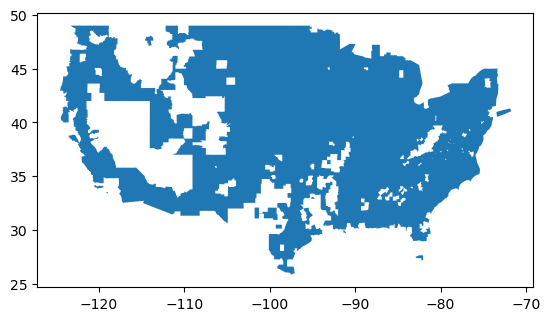

In [89]:
country_gpd = gpd.read_file(shapefile_path, crs="EPSG:4326")
country_gpd["adm_id"] = "{}-".format(ecmwf_country) + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
mismatches = [adm_id for adm_id in yield_data["adm_id"].unique() if adm_id not in country_gpd["adm_id"].unique()]
# drop adm_ids that are not in yield_data
country_gpd = country_gpd.loc[country_gpd["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)

if ecmwf_country == "US":
    country_gpd_shape = country_gpd.dissolve().to_crs("EPSG:4326")
else:
    country_gpd_shape = country_gpd.dissolve().set_crs("EPSG:4326")

country_gpd_shape.plot()

In [83]:
print(mismatches)

['US-01-998', 'US-05-998', 'US-06-998', 'US-08-998', 'US-13-998', 'US-16-998', 'US-17-998', 'US-18-998', 'US-19-998', 'US-20-998', 'US-21-998', 'US-22-998', 'US-24-998', 'US-26-998', 'US-27-998', 'US-28-998', 'US-29-998', 'US-31-998', 'US-36-998', 'US-37-998', 'US-38-998', 'US-39-998', 'US-40-998', 'US-42-998', 'US-45-998', 'US-46-998', 'US-47-998', 'US-48-998', 'US-51-998', 'US-53-998', 'US-55-998']


## 2. Preprocessing

#### 2.1 Resample to match 8-day bins

In [65]:
ecmwf_resampled = pp.resample_ecmwf(ecmwf, start_dates)
ecmwf_resampled.sample(3)

,time,location,start_date_bin,t2m,mx2t24,mn2t24,tp
386509,2019-04-01,"47, -105",2019-05-09,289.657739,292.24997,280.339511,0.082942
406661,2020-04-01,"44, -96",2020-07-27,300.387367,302.38639,292.973060,0.425113
116841,2008-04-01,"32, -98",2008-07-11,307.509142,309.61065,298.283556,0.249089


In [159]:
ecmwf

,time,step,latitude,longitude,surface,valid_time,t2m,mx2t24,mn2t24,tp
0,2003-04-01,1 days,49.0,-123.0,0.0,2003-04-02,277.88675,279.28960,273.56690,0.005552
1,2003-04-01,2 days,49.0,-123.0,0.0,2003-04-03,277.65652,278.56738,272.16962,0.009695
2,2003-04-01,3 days,49.0,-123.0,0.0,2003-04-04,276.99707,278.21988,271.43580,0.013883
3,2003-04-01,4 days,49.0,-123.0,0.0,2003-04-05,278.46094,279.03806,271.38898,0.015907
4,2003-04-01,5 days,49.0,-123.0,0.0,2003-04-06,277.66530,278.97473,271.95490,0.018534
...,...,...,...,...,...,...,...,...,...,...
3824200,2023-04-01,211 days,25.0,-81.0,0.0,2023-10-29,299.31714,300.92395,297.84482,0.793978
3824201,2023-04-01,212 days,25.0,-81.0,0.0,2023-10-30,299.04462,300.82993,297.50107,0.795887
3824202,2023-04-01,213 days,25.0,-81.0,0.0,2023-10-31,299.03442,300.66083,297.40900,0.797692
3824203,2023-04-01,214 days,25.0,-81.0,0.0,2023-11-01,298.98267,300.59058,297.31793,0.800431


In [160]:
meteo["date"] = pd.to_datetime(meteo["date"], format="%Y%m%d")

In [161]:
meteo.head()

,crop_name,adm_id,date,tmin,tmax,prec,rad,tavg,et0,cwb
0,maize,US-21-007,2000-01-01,4.225978,16.045619,0.076707,6.599781e+06,10.390492,1.275047,-1.198339
1,maize,US-21-017,2000-01-01,0.673304,14.696980,0.957616,6.104179e+06,9.367668,1.098156,-0.140540
2,maize,US-21-031,2000-01-01,4.042128,15.354265,0.385032,3.763873e+06,11.044964,1.055312,-0.670280
3,maize,US-21-065,2000-01-01,2.206065,15.651202,0.623994,5.879116e+06,10.702265,1.266038,-0.642044
4,maize,US-21-069,2000-01-01,0.324063,14.514311,0.672736,6.685615e+06,8.897802,1.130268,-0.457532


In [163]:
li = []
for year in list(range(2001, 2023)):
    meteo_year = meteo.loc[meteo["date"].dt.year == year]
    meteo_year_resampled = (meteo_year
                                    .groupby(["adm_id"]).resample("8D", on="date")[["tmin", "tmax", "prec", "rad", "tavg", "et0", "cwb"]].mean()
                                    .reset_index()
                                )
    li.append(meteo_year_resampled)

pd.concat(li).sample(3)

,adm_id,date,tmin,tmax,prec,rad,tavg,et0,cwb
50798,US-28-017,2020-04-22,11.170111,22.106148,7.271653,1.999330e+07,16.661882,3.930112,3.341542
37698,US-21-101,2022-07-12,21.362522,30.391122,7.037319,2.275286e+07,26.292057,5.024813,2.012507
59791,US-30-101,2013-10-24,-2.324937,9.021779,0.700352,8.770853e+06,3.263565,1.532392,-0.832039


#### 2.2 Assign counties to grid cells

In [93]:
counties_with_ecmwf_data = pp.assign_ecmwf_forecasts_to_counties(ecmwf_resampled, country_gpd, "adm_id")
counties_with_ecmwf_data.sample(3)

,init_date,modis_bin,adm_id,t2m,mx2t24,mn2t24,tp
1009410,2015-04-01,2015-04-07,US-39-169,282.955675,286.941090,277.875645,0.056994
1159014,2016-04-01,2016-09-21,US-47-143,295.153507,299.961706,290.477025,0.634787
277738,2006-04-01,2006-06-10,US-21-155,297.157209,300.767214,290.950131,0.268662


**TO-DOs:**
 - Remove tmean column
 - Convert units to match channels 7 (tmin), 8 (tmax), 9 (prcp)
 - bias-adjustment (once we know resampling logic)